In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path = "../data/eleme.xlsx"
df = pd.read_excel(
    path,
    sheet_name=0
)

/Users/tylerxie/airepo/edaagent/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
df.shape

(707, 10)

In [4]:
df.head()

,下单时间,订单号,商户信息,商品及数量,商品描述,收货人,地址,订单金额(元),订单状态,订单子类型
0,2025-11-02 19:21:27,8067986093855079925,上海本帮现炒浇头面,"1、商品:纯肉烤肠, 数量:1;\n2、商品:###不需要餐具, 数量:1;\n3、商品:葱...",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,20.78元,已完成,NaN
1,2025-10-31 19:12:33,8067986092873502180,遇见小面(辉煌国际店),"1、商品:销魂擂椒卤肉饭, 数量:1;\n2、商品:无需餐具包, 数量:1;\n3、商品:秘...",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,27.6元,已完成,NaN
2,2025-10-30 16:40:45,8067986092361811213,老广烧腊(盈创店),"1、商品:猪脚任性双拼饭, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,24.8元,已完成,NaN
3,2025-10-30 16:37:57,8067986092370346321,南城香-饭香串香馄饨香(西二旗店),"1、商品:虾仁大馄饨+羊肉串x3, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,21.3元,已完成,NaN
4,2025-10-29 16:05:15,8067986091942476182,南城香-饭香串香馄饨香(西二旗店),"1、商品:虾仁大馄饨+羊肉串x3, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,21元,已完成,NaN


### minimal version
1. data_loader (simple function, not agent)
2. eda_agent (code-as-action with reflection)
3. exec_sandbox (controlled exec)

User Query → Code Generator → Executor (V1) → Reflector → Code Generator → Executor (V2) → Results

In [30]:
# Standard library
import re
import io
import sys
import traceback
from pathlib import Path
from typing import Dict, Any, Optional

# Third-party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from IPython.display import display, Image, HTML
from openai import OpenAI
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI()

In [31]:
# Configure matplotlib for Chinese text rendering
import matplotlib
import platform

# Detect OS and set appropriate Chinese fonts
os_name = platform.system()

if os_name == "Darwin":  # macOS
    chinese_fonts = ['PingFang SC', 'STHeiti', 'Arial Unicode MS']
elif os_name == "Windows":
    chinese_fonts = ['Microsoft YaHei', 'SimHei', 'KaiTi']
else:  # Linux
    chinese_fonts = ['WenQuanYi Micro Hei', 'Noto Sans CJK SC', 'Droid Sans Fallback']

# Set font family with Chinese fonts first, then fallback to sans-serif
plt.rcParams['font.sans-serif'] = chinese_fonts + plt.rcParams['font.sans-serif']

# Fix minus sign display issue (common with Chinese fonts)
plt.rcParams['axes.unicode_minus'] = False

print(f"✓ Chinese font configuration loaded for {os_name}")
print(f"✓ Available fonts: {', '.join(chinese_fonts)}")

✓ Chinese font configuration loaded for Darwin
✓ Available fonts: PingFang SC, STHeiti, Arial Unicode MS


In [32]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load data from CSV or Excel file.
    
    Args:
        file_path: Path to the data file
        
    Returns:
        pandas DataFrame
        
    Raises:
        ValueError: If file format is not supported or file doesn't exist
    """
    path = Path(file_path)
    
    if not path.exists():
        raise ValueError(f"File not found: {file_path}")
    
    # Determine loader based on file extension
    if path.suffix.lower() == '.csv':
        df = pd.read_csv(file_path)
    elif path.suffix.lower() in ['.xlsx', '.xls']:
        df = pd.read_excel(file_path)
    else:
        raise ValueError(f"Unsupported file format: {path.suffix}. Use .csv, .xlsx, or .xls")
    
    # Basic validation
    if df.empty:
        raise ValueError("Loaded DataFrame is empty")
    
    print(f"✓ Loaded data: {df.shape[0]} rows × {df.shape[1]} columns")
    return df

In [33]:
def generate_eda_code(
    query: str,
    df: pd.DataFrame,
    model: str = "gpt-4o-mini",
    temperature: float = 0.3,
    include_viz: bool = True
) -> str:
    """
    Generate Python code for EDA task.
    
    Args:
        query: User's analysis request
        df: DataFrame to analyze (used for schema info)
        model: OpenAI model to use
        temperature: Sampling temperature
        include_viz: Whether to include visualization in the code
        
    Returns:
        Generated Python code wrapped in <execute_python> tags
    """
    # Build schema information
    schema_info = []
    schema_info.append(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    schema_info.append(f"\nColumns:")
    for col in df.columns:
        dtype = df[col].dtype
        null_count = df[col].isnull().sum()
        null_pct = (null_count / len(df)) * 100
        schema_info.append(f"  - {col}: {dtype} (nulls: {null_count}, {null_pct:.1f}%)")
    
    schema_info.append(f"\nFirst 3 rows:")
    schema_info.append(df.head(3).to_string())
    
    schema_text = "\n".join(schema_info)
    
    # Build prompt
    system_prompt = """You are a senior data analyst. Write clean, well-commented Python code for exploratory data analysis.

RULES:
1. Use pandas (pd), numpy (np), matplotlib (plt) ONLY
2. The DataFrame is available as 'df' variable
3. Write clear, step-by-step code with comments
4. Handle edge cases (empty results, missing values, etc.)
5. Store final answer/insight in a variable called 'result' (string or dict)
6. For visualizations:
   - Create clear, labeled plots
   - Use plt.title(), plt.xlabel(), plt.ylabel()
   - Don't call plt.show() (handled automatically)
7. Wrap your code in <execute_python>...</execute_python> tags
8. Keep it concise—focus on the specific request

OUTPUT FORMAT:
<execute_python>
# Step 1: Your first step
# ...

# Final insight
result = "Your insight here"
</execute_python>"""
    
    viz_instruction = " Include an appropriate visualization." if include_viz else ""
    
    user_prompt = f"""Dataset Schema:
{schema_text}

User Request:
{query}{viz_instruction}

Generate Python code to analyze this request."""
    
    # Call LLM
    response = client.chat.completions.create(
        model=model,
        temperature=temperature,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
    )
    
    return response.choices[0].message.content


In [34]:
def execute_code(
    code: str,
    df: pd.DataFrame,
    output_image_path: Optional[str] = None
) -> Dict[str, Any]:
    """
    Execute generated Python code in a controlled namespace.
    
    Args:
        code: Python code to execute (with or without <execute_python> tags)
        df: DataFrame to analyze
        output_image_path: Path to save matplotlib figures (optional)
        
    Returns:
        Dictionary containing:
            - code: Extracted Python code
            - stdout: Captured print statements
            - error: Error traceback (None if successful)
            - result: Value of 'result' variable if set by code
            - image_path: Path to saved image (if any)
    """
    # Extract code from tags if present
    match = re.search(r"<execute_python>(.*?)</execute_python>", code, re.DOTALL | re.IGNORECASE)
    code = match.group(1).strip() if match else code.strip()
    
    # Define safe globals (read-only access to libraries)
    safe_globals = {
        "pd": pd,
        "np": np,
        "plt": plt,
        "display": display,
        "Image": Image,
        "HTML": HTML,
    }
    
    # Define safe locals (includes the DataFrame)
    safe_locals = {"df": df.copy()}  # Work on a copy to prevent accidental mutations
    
    # Capture stdout
    stdout_buffer = io.StringIO()
    old_stdout = sys.stdout
    sys.stdout = stdout_buffer
    
    error = None
    try:
        exec(code, safe_globals, safe_locals)
        
        # Save any matplotlib figures
        if output_image_path and plt.get_fignums():
            plt.savefig(output_image_path, bbox_inches='tight', dpi=150)
            plt.close('all')  # Clean up
            
    except Exception:
        error = traceback.format_exc()
    finally:
        sys.stdout = old_stdout
    
    return {
        "code": code,
        "stdout": stdout_buffer.getvalue().strip(),
        "error": error,
        "result": safe_locals.get("result"),
        "image_path": output_image_path if output_image_path and Path(output_image_path).exists() else None,
    }

In [51]:
def reflect_and_improve(
    query: str,
    df: pd.DataFrame,
    v1_code: str,
    v1_result: Dict[str, Any],
    model: str = "gpt-4o-mini",
    temperature: float = 0.3
) -> str:
    """
    Reflect on V1 results and generate improved code.
    
    Args:
        query: Original user request
        df: DataFrame being analyzed
        v1_code: Code from V1
        v1_result: Execution results from V1
        model: OpenAI model to use
        temperature: Sampling temperature
        
    Returns:
        Improved Python code wrapped in <execute_python> tags
    """
    # Build feedback string
    feedback_parts = []
    
    if v1_result["error"]:
        feedback_parts.append(f"ERROR:\n{v1_result['error']}")
    
    if v1_result["stdout"]:
        feedback_parts.append(f"Output:\n{v1_result['stdout']}")
    
    if v1_result["result"]:
        feedback_parts.append(f"Result variable:\n{v1_result['result']}")
    
    if v1_result["image_path"]:
        feedback_parts.append(f"Visualization saved to: {v1_result['image_path']}")
    
    feedback = "\n\n".join(feedback_parts)
    
    # Build reflection prompt
    system_prompt = """You are a senior code reviewer. Review the V1 code and results, then generate IMPROVED code.

Your task:
1. Identify issues (errors, poor analysis choices, unclear visualizations)
2. Generate V2 code that fixes these issues. Use pandas (pd), numpy (np), matplotlib (plt) ONLY.
3. Make the analysis more insightful or visualization clearer
4. Keep the same output format and variable names

Return ONLY the improved code wrapped in <execute_python>...</execute_python> tags."""
    
    user_prompt = f"""Original Request:
{query}

V1 Code:
{v1_code}

V1 Execution Results:
{feedback}

Generate improved V2 code that addresses any issues and provides better analysis/visualization."""
    
    # Call LLM
    response = client.chat.completions.create(
        model=model,
        temperature=temperature,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
    )
    
    return response.choices[0].message.content

In [52]:
def eda_agent(
    query: str,
    df: pd.DataFrame,
    model: str = "gpt-4o-mini",
    use_reflection: bool = True,
    include_viz: bool = True,
    output_dir: str = "./output"
) -> Dict[str, Any]:
    """
    Main EDA agent that orchestrates the full workflow.
    
    Args:
        query: User's analysis request
        df: DataFrame to analyze
        model: OpenAI model to use
        use_reflection: Whether to use reflection pattern (V1 → V2)
        include_viz: Whether to include visualizations
        output_dir: Directory to save output images
        
    Returns:
        Dictionary containing:
            - query: Original request
            - v1: V1 execution results
            - v2: V2 execution results (if reflection enabled)
            - final_result: Best result (V2 if available, else V1)
    """
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    print(f"📊 EDA Agent Processing: {query}\n")
    
    # ===== V1: Initial code generation and execution =====
    print("🔄 Generating V1 code...")
    v1_code = generate_eda_code(
        query=query,
        df=df,
        model=model,
        include_viz=include_viz
    )
    
    print("⚙️  Executing V1 code...")
    v1_image_path = str(output_path / "v1_plot.png") if include_viz else None
    v1_result = execute_code(v1_code, df, v1_image_path)
    
    if v1_result["error"]:
        print(f"❌ V1 Error:\n{v1_result['error']}")
    else:
        print("✅ V1 execution successful")
    
    # ===== V2: Reflection and improved code =====
    v2_result = None
    if use_reflection:
        print("\n🤔 Reflecting on V1 results...")
        v2_code = reflect_and_improve(
            query=query,
            df=df,
            v1_code=v1_result["code"],
            v1_result=v1_result,
            model=model
        )
        
        print("⚙️  Executing V2 code...")
        v2_image_path = str(output_path / "v2_plot.png") if include_viz else None
        v2_result = execute_code(v2_code, df, v2_image_path)
        
        if v2_result["error"]:
            print(f"❌ V2 Error:\n{v2_result['error']}")
            print("⚠️  Using V1 results as fallback")
        else:
            print("✅ V2 execution successful")
    
    # ===== Select best result =====
    final_result = v2_result if (v2_result and not v2_result["error"]) else v1_result
    
    print("\n" + "="*60)
    print("📊 FINAL RESULT")
    print("="*60)
    
    if final_result["result"]:
        print(f"\n{final_result['result']}")
    
    if final_result["stdout"]:
        print(f"\n{final_result['stdout']}")
    
    if final_result["image_path"]:
        print(f"\n📈 Visualization: {final_result['image_path']}")
        display(Image(filename=final_result["image_path"]))
    
    return {
        "query": query,
        "v1": v1_result,
        "v2": v2_result,
        "final_result": final_result,
    }

In [53]:
df_eleme = load_data("../data/eleme.xlsx")

✓ Loaded data: 707 rows × 10 columns


/Users/tylerxie/airepo/edaagent/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [54]:
df_eleme.head()

,下单时间,订单号,商户信息,商品及数量,商品描述,收货人,地址,订单金额(元),订单状态,订单子类型
0,2025-11-02 19:21:27,8067986093855079925,上海本帮现炒浇头面,"1、商品:纯肉烤肠, 数量:1;\n2、商品:###不需要餐具, 数量:1;\n3、商品:葱...",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,20.78元,已完成,NaN
1,2025-10-31 19:12:33,8067986092873502180,遇见小面(辉煌国际店),"1、商品:销魂擂椒卤肉饭, 数量:1;\n2、商品:无需餐具包, 数量:1;\n3、商品:秘...",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,27.6元,已完成,NaN
2,2025-10-30 16:40:45,8067986092361811213,老广烧腊(盈创店),"1、商品:猪脚任性双拼饭, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,24.8元,已完成,NaN
3,2025-10-30 16:37:57,8067986092370346321,南城香-饭香串香馄饨香(西二旗店),"1、商品:虾仁大馄饨+羊肉串x3, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,21.3元,已完成,NaN
4,2025-10-29 16:05:15,8067986091942476182,南城香-饭香串香馄饨香(西二旗店),"1、商品:虾仁大馄饨+羊肉串x3, 数量:1;\n",NaN,谢(先生),西二旗智学苑4号楼2309请放门口,21元,已完成,NaN


📊 EDA Agent Processing: tell me about the data and what are the interesting findings.

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful

📊 FINAL RESULT

{'data_shape': (707, 10), 'data_types': {'下单时间': dtype('O'), '订单号': dtype('int64'), '商户信息': dtype('O'), '商品及数量': dtype('O'), '商品描述': dtype('O'), '收货人': dtype('O'), '地址': dtype('O'), '订单金额(元)': dtype('O'), '订单状态': dtype('O'), '订单子类型': dtype('O')}, 'missing_values': {'下单时间': 0, '订单号': 0, '商户信息': 0, '商品及数量': 0, '商品描述': 705, '收货人': 18, '地址': 33, '订单金额(元)': 0, '订单状态': 0, '订单子类型': 705}, 'order_amount_distribution': {'count': 707.0, 'mean': 38.4453323903819, 'std': 36.942393931642975, 'min': 0.0, '25%': 22.0, '50%': 30.0, '75%': 41.45, 'max': 462.41}, 'most_common_order_status': '已完成', 'most_common_order_status_count': np.int64(677)}

📈 Visualization: output/v2_plot.png


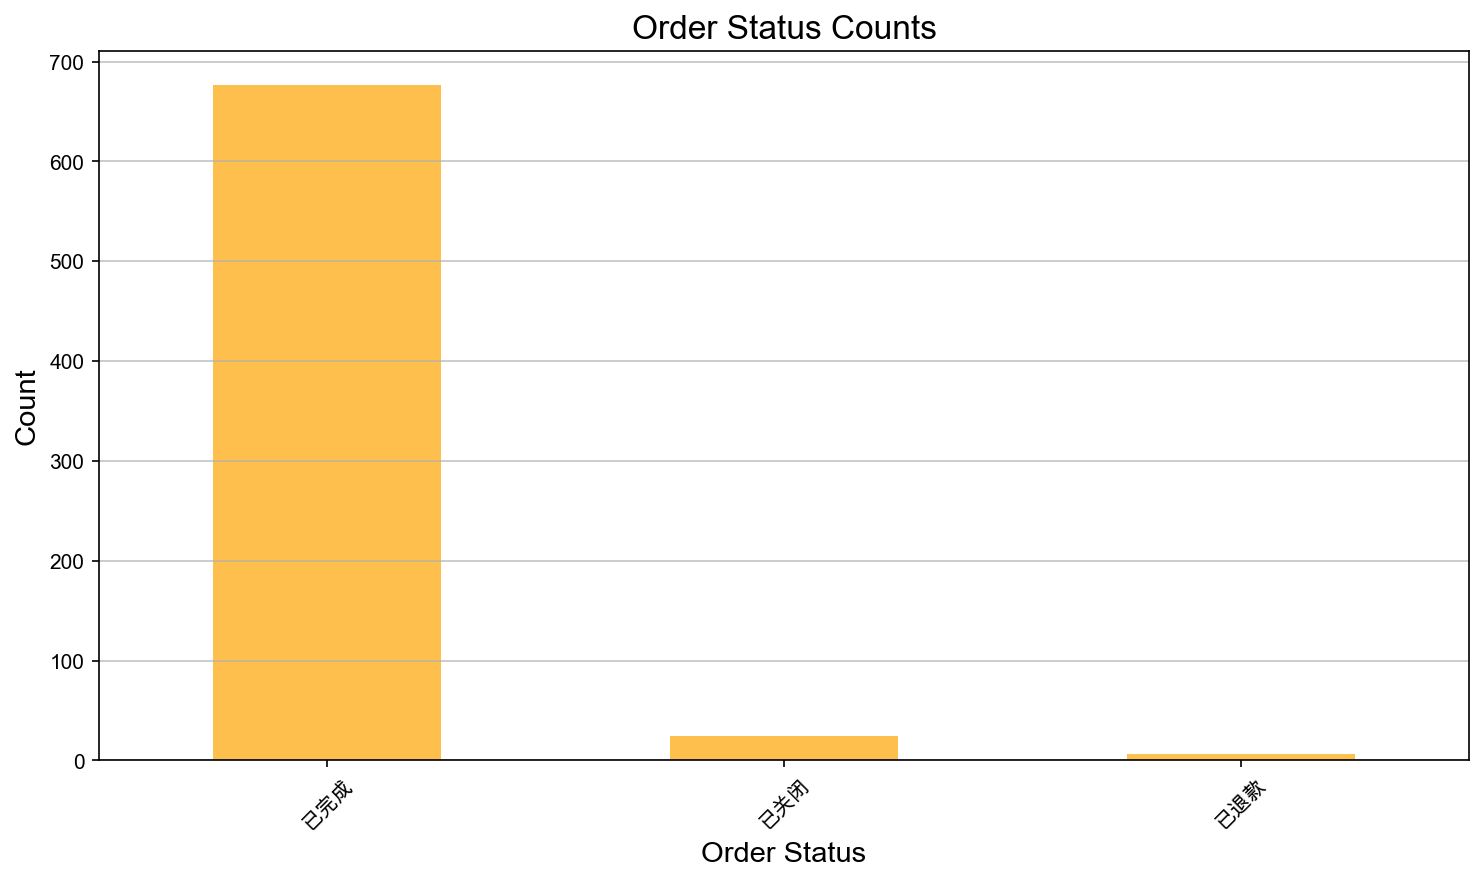

In [55]:
result1 = eda_agent(
    query="tell me about the data and what are the interesting findings.",
    df=df_eleme,
    model="gpt-4o-mini",
    use_reflection=True,
    include_viz=True
)

In [56]:
result1

{'query': 'tell me about the data and what are the interesting findings.',
 'v1': {'code': 'import pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Step 1: Check the shape and data types of the DataFrame\ndata_shape = df.shape\ndata_types = df.dtypes\n\n# Step 2: Check for missing values in the DataFrame\nmissing_values = df.isnull().sum()\n\n# Step 3: Convert \'订单金额(元)\' to numeric after removing the \'元\' character\ndf[\'订单金额(元)\'] = df[\'订单金额(元)\'].str.replace(\'元\', \'\').astype(float)\n\n# Step 4: Analyze the distribution of order amounts\norder_amount_distribution = df[\'订单金额(元)\'].describe()\n\n# Step 5: Visualize the distribution of order amounts\nplt.hist(df[\'订单金额(元)\'].dropna(), bins=30, color=\'blue\', alpha=0.7)\nplt.title(\'Distribution of Order Amounts\')\nplt.xlabel(\'Order Amount (元)\')\nplt.ylabel(\'Frequency\')\n\n# Step 6: Identify the most common order status\norder_status_counts = df[\'订单状态\'].value_counts()\n\n# Step 7: Visualize the order s

📊 EDA Agent Processing: tell me about the data and what are the interesting findings.

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
❌ V2 Error: Traceback (most recent call last):
  File "/var/folders/f4/n64j5lvd2gb_tm4kxbd55qsc0000gn/T/ipykernel_12539/2377752704.py", line 46, in execute_code
    exec(code, safe_globals, safe_locals)
  File "<...
⚠️  Using V1 results as fallback

📊 FINAL RESULT

{'shape': (707, 10), 'missing_values': {'下单时间': 0, '订单号': 0, '商户信息': 0, '商品及数量': 0, '商品描述': 705, '收货人': 18, '地址': 33, '订单金额(元)': 0, '订单状态': 0, '订单子类型': 705}, 'order_amount_stats': {'count': 707.0, 'mean': 38.4453323903819, 'std': 36.942393931642975, 'min': 0.0, '25%': 22.0, '50%': 30.0, '75%': 41.45, 'max': 462.41}, 'top_merchants': ['老广烧腊(盈创店)', '新扎师兄冰室(西三旗店)', '西部马华牛肉面清真(回龙观店)', '麦田归来本地生活店', '南城香-饭香串香馄饨香(西二旗店)', '麦田归来·国民拌饭·四季轻食(上地店)', '活卤君辣卤·生腌海鲜(空港店)', 'FOODBOWL超级碗(辉煌国际店)', '孔雀记忆PHO越南粉·咖喱饭(尚科美食城店)', '东发道茶冰厅(

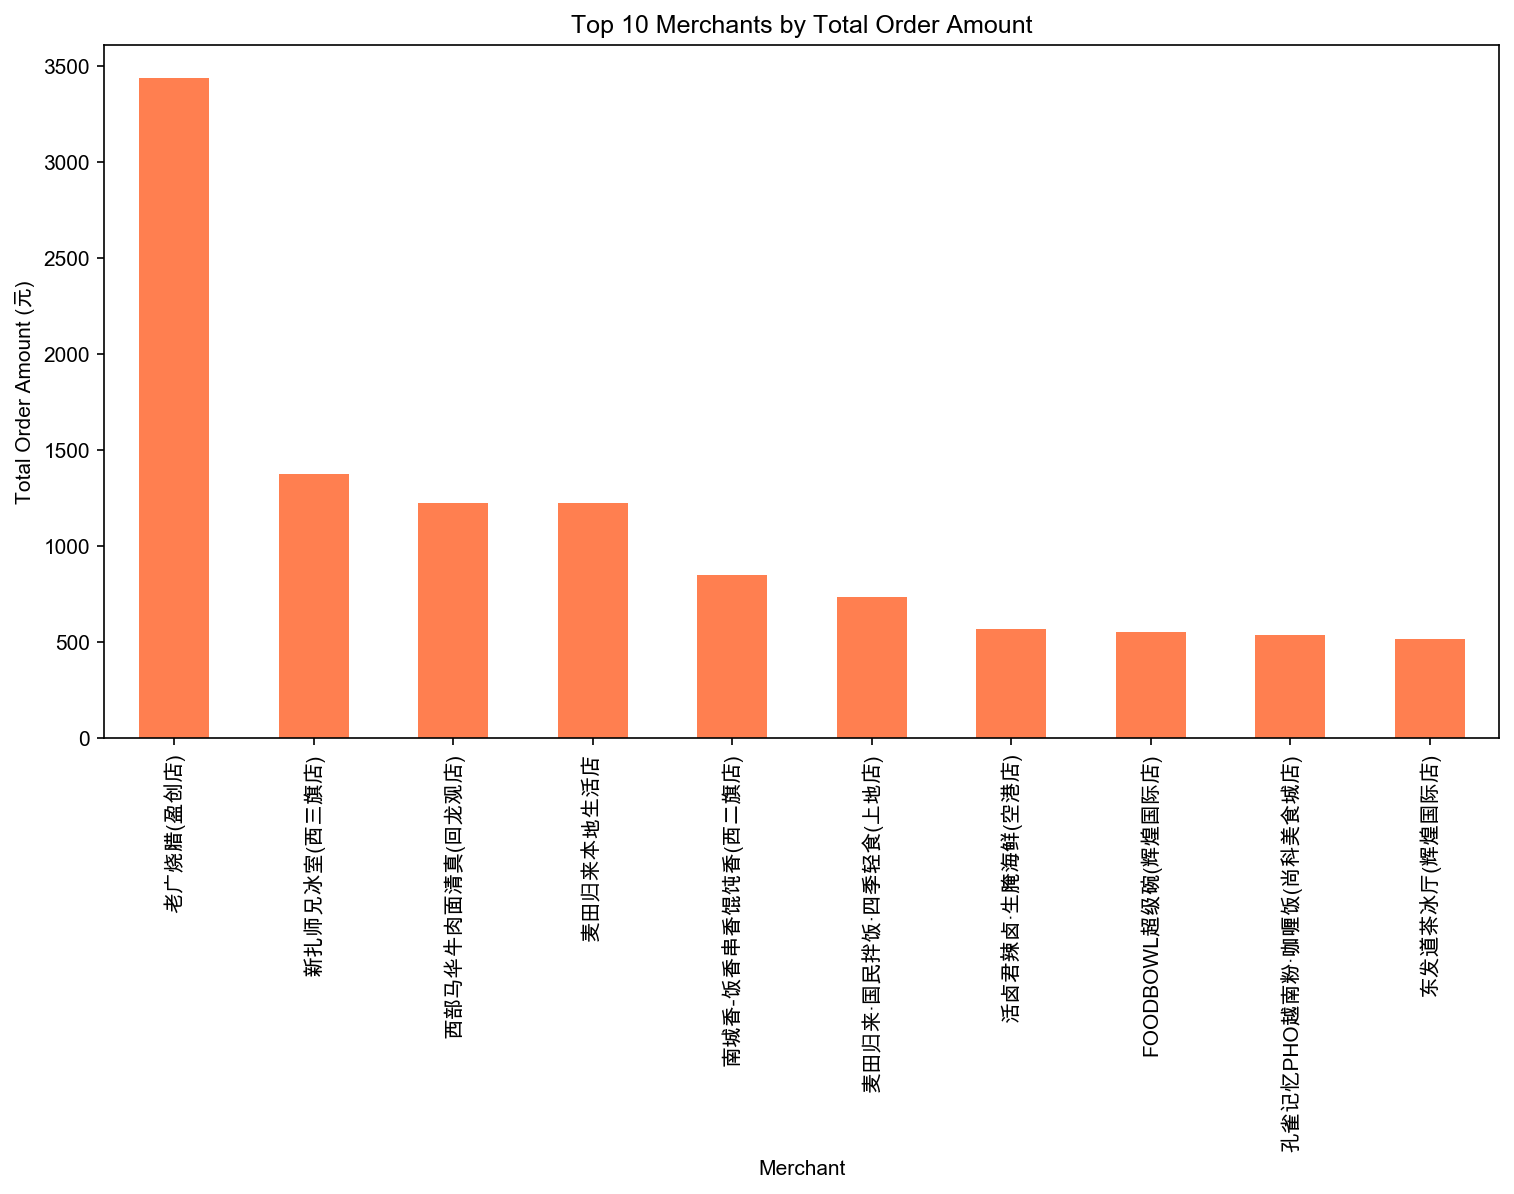

In [39]:
result1 = eda_agent(
    query="tell me about the data and what are the interesting findings.",
    df=df_eleme,
    model="gpt-4o-mini",
    use_reflection=True,
    include_viz=True
)

In [29]:
v2_result

NameError: name 'v2_result' is not defined